# Punto 1 y 2

Comentado en PDF

# Punto 2 y 4

Importamos las librerías que vamos a utilizar

In [1]:
from datetime import datetime

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec

import pandas as pd

import seaborn as sns
import  shutil, os

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input



Cargamos el dataset un pandas dataframe y ya escalamos todas las imágenes a un tamaño determinado

In [2]:
img_folder = 'imgs'
label_folder = 'label'

def image_df(path, image_size=(256,256), extension= '.jpg'):
    """
    Función que vuelva el contenido completo de un directorio con imágenes en un dataset.i
    Información por columnas: 
        path: ruta original del archivo.
        file: nombre del archivo.
        image_original_size: imagen original.
        image: imagen escalada.
        size: tamaño original de la imagen.

    Args:
        path (str): ruta del directorio a volcar
        image_size (tuple, optional): tamaño de imagen normalizada. Defaults to (256,256).

    Returns:
        Pandas dataframe.
    """
    
    file_names = os.listdir(path)
    images = [{ 'path': os.path.abspath(os.path.join(img_folder,f)),
                'file': f, 
                'image_original_size': image.load_img(os.path.join(img_folder,f)),
                'image': image.load_img(os.path.join(img_folder,f), target_size=image_size),
                'size': image.load_img(os.path.join(img_folder,f)).size
                 } for f in file_names if f .endswith(extension)]
    return pd.DataFrame(images)


In [3]:
image_size= (200,200)
df = image_df(os.path.join('.',img_folder), image_size= (200,200))

Efectivcamente las imágenes originales tienen diferentes tamaño

In [4]:
df['size'].sample(7)

627     (500, 333)
1225    (159, 240)
827     (500, 400)
799     (320, 213)
1546    (320, 285)
1120    (320, 240)
1242    (180, 240)
Name: size, dtype: object

Creamos una función para visualizar imágenes aleatorias del dataset

In [5]:
def print_flowers(df, num_examples = 9, col='image', size = (15,10)):
    """
    Función que imprime por consola un número imágenes aleatoriamente escogidas de un Pandas dataframe.

    Args:
        df (Pandas dataframe): Dataframe contenedor de imágenes
        num_examples (int, optional): Número de imágenes a mostrar. Defaults to 9.
        col (str, optional): Nombre de la columna que contiene las imágenes. Defaults to 'image'.
        size (tuple, optional): Tamaño de la figura que contiene las imágenes. Defaults to (15,10).

    Returns: None
    """
    
    try:
        num_imgs_df = df.shape[0]
        num_imgs_show = min(num_examples, num_imgs_df)
        
        print("Número de imágenes: ", num_imgs_df)

        df_examples = df.sample(num_imgs_show)
        gs = gridspec.GridSpec(int(np.ceil(np.sqrt(num_imgs_show))), int(np.ceil(np.sqrt(num_imgs_show))))
        plt.figure(figsize = size)

        for i in range(0, num_imgs_show):
            plt.subplot(gs[i])
            plt.imshow(df_examples.reset_index()[col][i])    
            plt.axis('off')
    except Exception as e:
        print("Ha surgido un problemaal imprimir")
        print(e)


Imprimimos imágenes del dataset

Número de imágenes:  1567


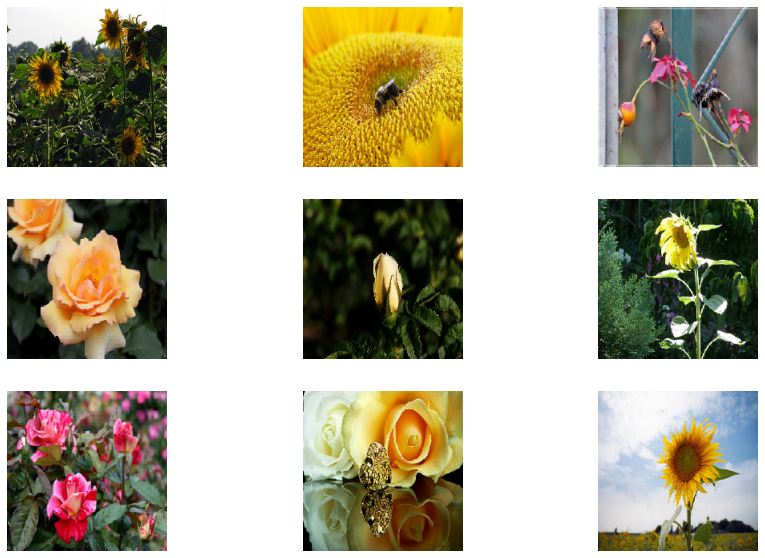

In [6]:
print_flowers(df)

A cada una de estas imágenes le extraemos las features mediante una red preentrenada para imágens. La escogida, por su simplicidad a pesar de haber ganado ImageNet 2012 es la ResNet50. Esta librería preentrenada con imágenes nos permitirá extraer features para nuestro clasificador. Uitlizamos parámetro  de pesos 'imagenet' (pre-entrenamiento con ImageNet) y no incluímos las capas clasificadoras. 

In [7]:
model = ResNet50(weights='imagenet', include_top=False, input_shape= (image_size[0],image_size[1],3));

2021-10-19 15:54:22.805008: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Extraemos todas las feautres de cada imagen

In [10]:
def extract_features(img, model):
    """Función que extrae las features de una imagen.

    Args:
        img (Image): Imagen a extraer features
        model (Keras engine): Modelo con el que extraer las variables.

    Returns:
        [Numpy array]: Array con todas las features de la imagen.
    """
    x = image.img_to_array(img)
    y = np.expand_dims(x, axis=0)
    z = preprocess_input(y)
    return model.predict(z,  batch_size=32).flatten()


In [11]:
df['features']= df.image.apply(lambda x: extract_features(x,model)) #No he conseguido hacerlo vectorizado con numpy y me he decantado por hacerlo con un apply a sabiendas de lo eficiente que sería en numpy

2021-10-19 15:55:13.165915: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


In [12]:
print("El vector que obtenemos es de longitud: ", df.loc[0,'features'].shape[0])

El vector que obtenemos es de longitud:  100352


Podemos utilizar “Análisis de Componentes Principales” o PCA para dereeducir el número de variables ya que una imagen existe mucha información redundante.

Lo primero que haremos será calcular la varianza que permanece a pesar de esta reducción.

In [13]:
max_features = 1500 #máximo de 1500 variables
pca = PCA(n_components = max_features)
pca.fit(df['features'].to_list())
var=np.cumsum(pca.explained_variance_ratio_)

Pediremos mantener cierta varianza para no perder demasiada información en este proceso.

In [14]:
var_min = 0.8
n_features = next(x[0] for x in enumerate(var) if x[1] > var_min)
print(f'Tendremos {n_features} variables')

Tendremos 694 variables


Podemos ver como evoluciona la varianza tras el PCA en funcíon del número de variables:

Text(0, 0.5, '% variance')

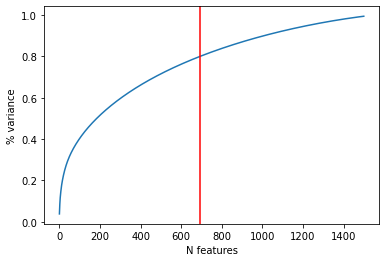

In [15]:
plt.plot(var)
plt.axvline(x=n_features, c='r')

plt.xlabel("N features")
plt.ylabel("% variance")

Aplicamos a nuestro array de features el PCA.

In [16]:
pca = PCA(n_components = n_features)
pca.fit(df['features'].to_list())

PCA(n_components=694)

In [17]:

df['features_pca'] = pca.transform(df['features'].tolist()).tolist()

Hemos guardado esta información en una sola columna, desplegamos por comodidad este array a columnas.

Nombramos las columnas:

In [18]:
pca_columns= ["pca_" + str(i+1) for i in range(n_features)]

Desplegamos las variables en las columnas del dataframe:

In [19]:
for i, r in df.iterrows():
    df.loc[i, pca_columns]=r['features_pca'] #seguramente haya un código mucho más eficiente que hacerlo con este for

Y este sería el PD con el que vamos a trabajar:

In [20]:
df.sample(3)

path            file  \
1407  /Users/emilio/Trabajo/komorebi/imgs/imagen1252...  imagen1252.jpg   
611   /Users/emilio/Trabajo/komorebi/imgs/imagen599.jpg   imagen599.jpg   
178   /Users/emilio/Trabajo/komorebi/imgs/imagen869.jpg   imagen869.jpg   

                                    image_original_size  \
1407  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
611   <PIL.JpegImagePlugin.JpegImageFile image mode=...   
178   <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                                  image        size  \
1407  <PIL.Image.Image image mode=RGB size=200x200 a...  (500, 325)   
611   <PIL.Image.Image image mode=RGB size=200x200 a...  (179, 240)   
178   <PIL.Image.Image image mode=RGB size=200x200 a...  (320, 240)   

                                               features  \
1407  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
611   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.175...   
178   [0.0, 0.53099775, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   

                                           features_pca       pca_1  \
1407  [120.87270427966888, 32.2550975775412, 24.6519...  120.872704   
611   [-98.63027199934349, 43.109529046943784, 50.33...  -98.630272   
178   [-106.71641289586297, 117.9583799808268, 36.38... -106.716413   

           pca_2      pca_3  ...    pca_685   pca_686    pca_687   pca_688  \
1407   32.255098  24.651954  ...  -6.288680 -1.928646  -5.042255  0.601324   
611    43.109529  50.337503  ...  11.089350  0.423861  21.230706 -0.266177   
178   117.958380  36.387705  ...   9.182684 -0.411290  13.956903  1.895430   

        pca_689    pca_690   pca_691   pca_692   pca_693    pca_694  
1407   0.577073  12.586479 -3.802658  6.065166  4.835833  -8.207764  
611   13.917946 -13.134787  9.902221  8.241893 -1.963659  -1.674094  
178    2.056483   2.290564  0.474354  1.423014 -0.504708  12.590327  

[3 rows x 701 columns]

# Clusterización

Una vez extraidas las features y reducido su número con el PCA podemos comenzar a clusterizar

Para clusterizar elegimos el algoritmo de K means por ser el más habitual en la literatura para clusterización de imágenes. Las características fundamentales de este algoritmo son: es de propósito general, tamaño de clúster uniforme, geometría plana, no demasiados clusters, inductivo.

Vamos a determinar el número de clusters mediante el método elbow

In [21]:
def print_k(x, ini=1, end=20):
    """ Función para imprimir la SSE por cada número de cluster.
    Args:
        x (Numpy array): Numpy array de puntos
        ini (int, optional): num_de cluster inicial. Defaults to 1.
        end (int, optional): num de cluster final. Defaults to 20.
    """
    sse = {}
    
    for k in range(ini, end+1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(x)
        sse[k] = kmeans.inertia_

    import matplotlib.pylab as plt
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel('k')
    plt.ylabel('SEE')
    plt.title('Curva K')
    plt.show()    

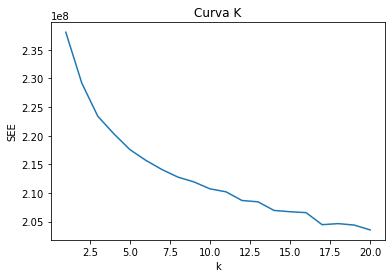

In [22]:
print_k(df[pca_columns])

Montamos el modelo de kmeans con el número de cluster igual a 5. Esto es un número mayor que las clases a diferenciar pero parece sensato intentar encontrar subgrupos dentro de las imágenes de girasoles y rosas, además de una tercera clase que sería "desconocido" (ya que hay muchas imágenes que no son ni girasoles ni rosas)

In [23]:
k =5
kmeans = KMeans(n_clusters = k)

Asignamos a cada imagen su etiqueta.

In [24]:
df['labels_kmeans'] = kmeans.fit_predict(df[pca_columns])

Text(0, 0.5, 'Count')

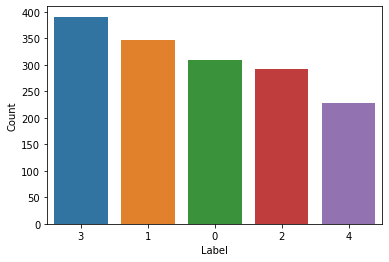

In [25]:
sns.countplot(x=df['labels_kmeans'], order = df['labels_kmeans'].value_counts().index)
plt.xlabel("Label")
plt.ylabel("Count")

In [26]:
df.labels_kmeans.value_counts()

3    391
1    347
0    309
2    292
4    228
Name: labels_kmeans, dtype: int64

# Enriquecimiento Dataset

Obtenemos los centroides:

In [27]:
centroids = kmeans.cluster_centers_

df_centroides = pd.DataFrame(centroids)
df_centroides.columns = pca_columns
df_centroides

pca_1      pca_2      pca_3      pca_4      pca_5      pca_6  \
0  -82.138789 -81.872722  17.928149  -9.257176   4.193252  20.393513   
1   75.411586  12.581925  62.563952  -2.651966  -9.064207  13.468951   
2   12.420012 -45.120467 -36.527623  51.175647  -7.728807 -30.747520   
3  -76.301976  88.339008 -13.690435  -3.752933   3.144857  -6.097716   
4  111.493399  -1.897513 -49.256418 -42.522774  12.617270   1.698076   

      pca_7      pca_8      pca_9     pca_10  ...   pca_685   pca_686  \
0  1.234389  15.692311  11.932452   6.358429  ...  0.029414  0.241842   
1  6.678699  -8.680672  -1.596241  -1.677388  ... -0.074582 -0.477206   
2 -1.499657 -21.496131  -6.851629 -14.605972  ...  0.212511  0.091137   
3 -0.954086  -0.291802  -2.727705   0.170699  ... -0.179426  0.052546   
4 -8.280646  19.974711  -0.289577  12.348684  ...  0.109181  0.191683   

    pca_687   pca_688   pca_689   pca_690   pca_691   pca_692   pca_693  \
0 -0.164111 -0.101054 -0.109196  0.072609  0.091890  0.031336  0.122496   
1 -0.235089 -0.073005  0.266837 -0.047433 -0.059825 -0.115659  0.055160   
2  0.232418 -0.048642 -0.053561 -0.245402  0.229377  0.128919 -0.043911   
3 -0.156479 -0.059694  0.041403  0.101654 -0.149524 -0.097900 -0.124245   
4  0.550892  0.412729 -0.260525  0.113744 -0.070828  0.136339  0.019343   

    pca_694  
0 -0.370735  
1  0.169376  
2  0.320376  
3  0.073583  
4 -0.291830  

[5 rows x 694 columns]

Veamos cómo es la distribución según las etiquetas:

In [28]:
def dist_centroid(df, columns, df_cent):
    """
    Función que añade al DF las distancias a cada centroide en columnas nombradas 'dis_centroid_i'

    Args:
        df (Pandas df): contiene todas las features
        pca_columns ( lista): lista que contiene todas las columnas de las features originales
        df_centroides (Pandas dF): [description]contiene las coordenadas de todos los centroides
    """

    columns_dist=['dist_centroid_' + str(i) for i in df_cent.index]
    for i in df_cent.index: 
        df[columns_dist[i]] = np.sqrt(((df[columns].sub(df_cent.iloc[i].tolist(), axis= 'columns'))**2).sum(axis=1))
    return df

Guardamos los centroides para poder enriquecer el dataset cuando tengamos imágenes sin etiquetar.

In [29]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns= pca_columns)
centroids

pca_1      pca_2      pca_3      pca_4      pca_5      pca_6  \
0  -82.138789 -81.872722  17.928149  -9.257176   4.193252  20.393513   
1   75.411586  12.581925  62.563952  -2.651966  -9.064207  13.468951   
2   12.420012 -45.120467 -36.527623  51.175647  -7.728807 -30.747520   
3  -76.301976  88.339008 -13.690435  -3.752933   3.144857  -6.097716   
4  111.493399  -1.897513 -49.256418 -42.522774  12.617270   1.698076   

      pca_7      pca_8      pca_9     pca_10  ...   pca_685   pca_686  \
0  1.234389  15.692311  11.932452   6.358429  ...  0.029414  0.241842   
1  6.678699  -8.680672  -1.596241  -1.677388  ... -0.074582 -0.477206   
2 -1.499657 -21.496131  -6.851629 -14.605972  ...  0.212511  0.091137   
3 -0.954086  -0.291802  -2.727705   0.170699  ... -0.179426  0.052546   
4 -8.280646  19.974711  -0.289577  12.348684  ...  0.109181  0.191683   

    pca_687   pca_688   pca_689   pca_690   pca_691   pca_692   pca_693  \
0 -0.164111 -0.101054 -0.109196  0.072609  0.091890  0.031336  0.122496   
1 -0.235089 -0.073005  0.266837 -0.047433 -0.059825 -0.115659  0.055160   
2  0.232418 -0.048642 -0.053561 -0.245402  0.229377  0.128919 -0.043911   
3 -0.156479 -0.059694  0.041403  0.101654 -0.149524 -0.097900 -0.124245   
4  0.550892  0.412729 -0.260525  0.113744 -0.070828  0.136339  0.019343   

    pca_694  
0 -0.370735  
1  0.169376  
2  0.320376  
3  0.073583  
4 -0.291830  

[5 rows x 694 columns]

Calculamos la distancia al centroide

In [30]:
df = dist_centroid(df, pca_columns, df_centroides)
df.sample(7)

path            file  \
497   /Users/emilio/Trabajo/komorebi/imgs/imagen1215...  imagen1215.jpg   
602   /Users/emilio/Trabajo/komorebi/imgs/imagen214.jpg   imagen214.jpg   
1045  /Users/emilio/Trabajo/komorebi/imgs/imagen1393...  imagen1393.jpg   
1345  /Users/emilio/Trabajo/komorebi/imgs/imagen643.jpg   imagen643.jpg   
595   /Users/emilio/Trabajo/komorebi/imgs/imagen1211...  imagen1211.jpg   
168   /Users/emilio/Trabajo/komorebi/imgs/imagen1471...  imagen1471.jpg   
925   /Users/emilio/Trabajo/komorebi/imgs/imagen146.jpg   imagen146.jpg   

                                    image_original_size  \
497   <PIL.JpegImagePlugin.JpegImageFile image mode=...   
602   <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1045  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1345  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
595   <PIL.JpegImagePlugin.JpegImageFile image mode=...   
168   <PIL.JpegImagePlugin.JpegImageFile image mode=...   
925   <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                                  image        size  \
497   <PIL.Image.Image image mode=RGB size=200x200 a...  (320, 210)   
602   <PIL.Image.Image image mode=RGB size=200x200 a...  (191, 240)   
1045  <PIL.Image.Image image mode=RGB size=200x200 a...  (500, 327)   
1345  <PIL.Image.Image image mode=RGB size=200x200 a...  (240, 159)   
595   <PIL.Image.Image image mode=RGB size=200x200 a...  (500, 331)   
168   <PIL.Image.Image image mode=RGB size=200x200 a...  (500, 331)   
925   <PIL.Image.Image image mode=RGB size=200x200 a...  (375, 499)   

                                               features  \
497   [0.0, 0.0, 0.0, 0.0, 1.3917865, 0.0, 0.0, 0.0,...   
602   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1045  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1345  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.847...   
595   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
168   [0.0, 0.0, 0.0, 0.015888453, 0.0, 0.0, 0.0, 0....   
925   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                           features_pca       pca_1  \
497   [-100.03282937086267, 24.830553878193786, -36.... -100.032829   
602   [75.25708031582771, -54.98643042415706, -76.11...   75.257080   
1045  [-109.83031525716459, 168.34208941337258, -41.... -109.830315   
1345  [-54.859521348052155, -89.26543631618921, 111....  -54.859521   
595   [-66.00210200577627, -43.84598956969694, 26.01...  -66.002102   
168   [-97.29577960924814, 113.05519998127541, -79.9...  -97.295780   
925   [37.859649825370774, -46.5719061698524, -107.8...   37.859650   

           pca_2       pca_3  ...    pca_691    pca_692    pca_693   pca_694  \
497    24.830554  -36.453405  ...   0.954496  10.828828   4.260380  5.930189   
602   -54.986430  -76.116255  ...  -9.474480  -4.089725 -18.699677  3.270323   
1045  168.342089  -41.547458  ...  -5.860750  -7.995098   2.107334 -9.461924   
1345  -89.265436  111.471810  ...   3.562526   2.026346   0.811959  5.390778   
595   -43.845990   26.011119  ...   9.727690 -10.138967  -3.584961 -5.791663   
168   113.055200  -79.910291  ...   0.941598   6.882300   2.150387  3.466627   
925   -46.571906 -107.845900  ... -11.938723 -10.378907  21.404240 -3.714840   

      labels_kmeans  dist_centroid_0  dist_centroid_1  dist_centroid_2  \
497               3       469.667307       499.158538       477.794168   
602               4       430.797658       416.778628       401.156442   
1045              3       341.641257       342.975161       342.703449   
1345              0       216.913934       263.221068       277.966191   
595               0       262.370993       299.653788       276.987253   
168               3       344.599905       360.758817       354.716876   
925               2       431.081697       429.881438       389.256739   

      dist_centroid_3  dist_centroid_4  
497        456.902152       502.589073  
602        443.292126       396.539953  
1045     

# Nombramiento de etiquetas

Podemos ver cómo ha etiquetado cada imagen el k menas

In [31]:
def print_flowers_cat(df, labels = 'labels_kmeans', num = 16, label_text=None):
    """Imprime por pantalla imágenes aleatorias contenidas ean un dataset agrupadas por etiquetas. Si label_text no está vacía pregunta por las etiquetas de cada una de las categorías.

    Args:
        df (Pandas DF): Pandas dataframe conteniendo imágenes
        labels (str, optional): Columna que contiene la etiqueta d ecada imagen. Defaults to 'labels_kmeans'.
        num (int, optional): Número de imágenes a mostrar. Defaults to 16.
        label_text (list of strings, optional): lista con etiquetas. Defauls to 'None'. Si None no se pregunta por el nombre de las categorias.

    Returns:
        Diccionario con el texto asociado a cada una de las etiquetas. Si no se ha preguntado devuelve None
    """
    dict_ = dict()
    for i in df[labels].unique():
        print("===============================")
        print("Etiqueta: ", i)
        print_flowers(df[df[labels] == i],num)
        plt.show()
        if label_text:
            question = [str(i) + '-' + s  for i,s in enumerate(label_text)]
            dict_[i] = label_text[int(input(question))]

    return dict_

Etiqueta:  1
Número de imágenes:  347


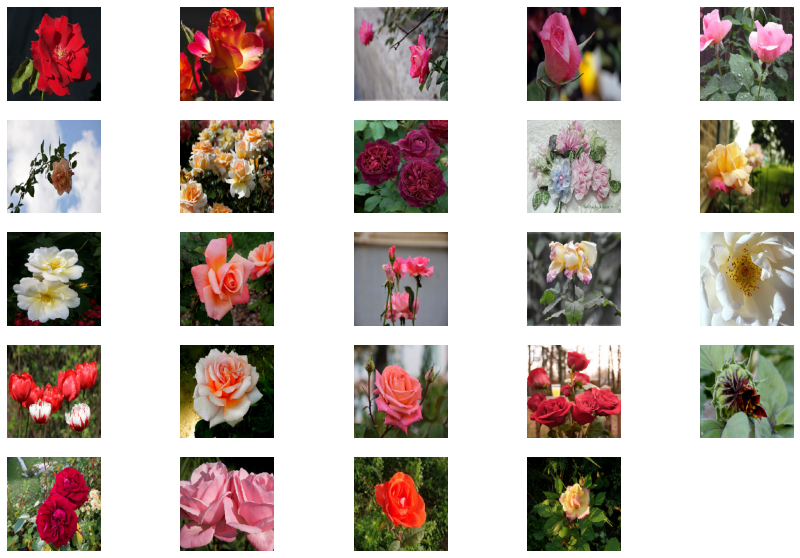

Etiqueta:  3
Número de imágenes:  391


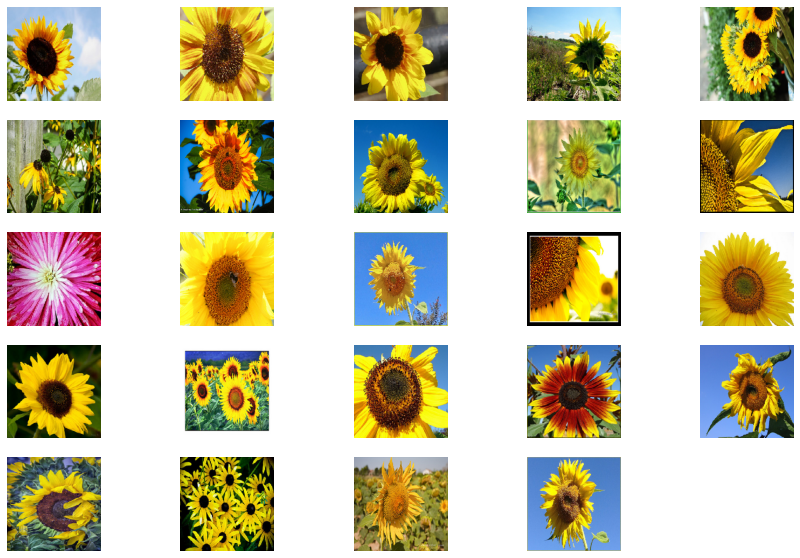

Etiqueta:  0
Número de imágenes:  309


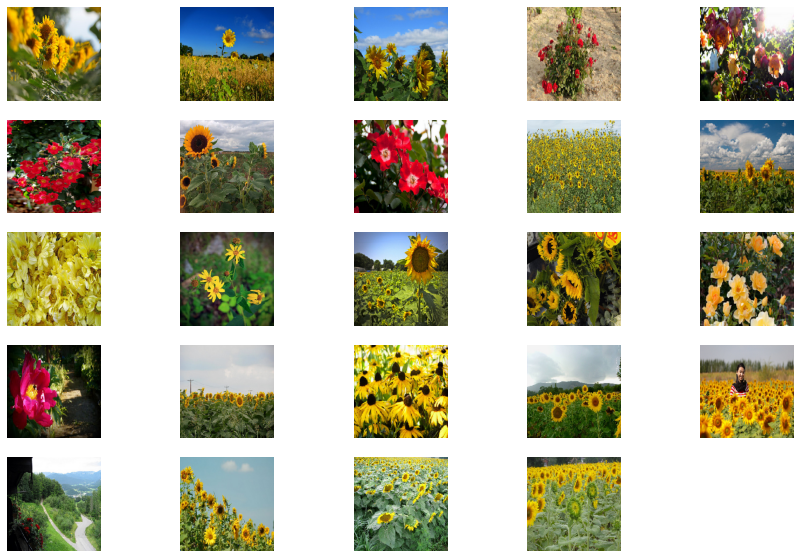

Etiqueta:  4
Número de imágenes:  228


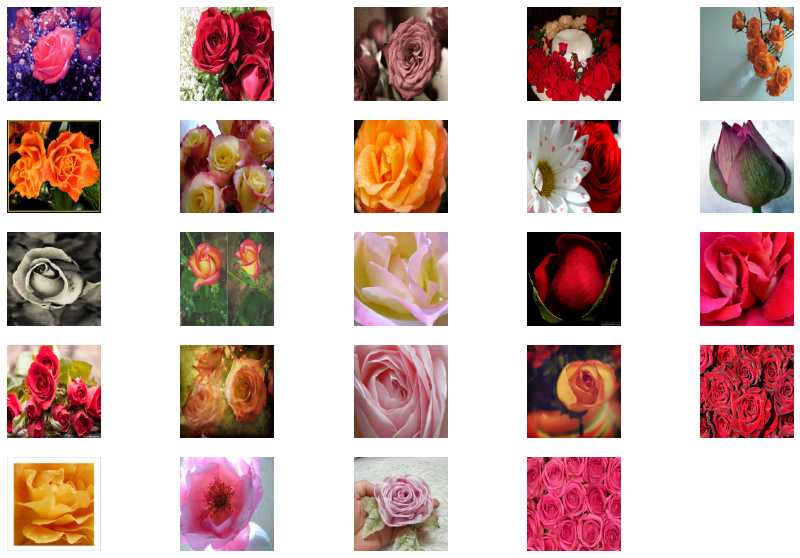

Etiqueta:  2
Número de imágenes:  292


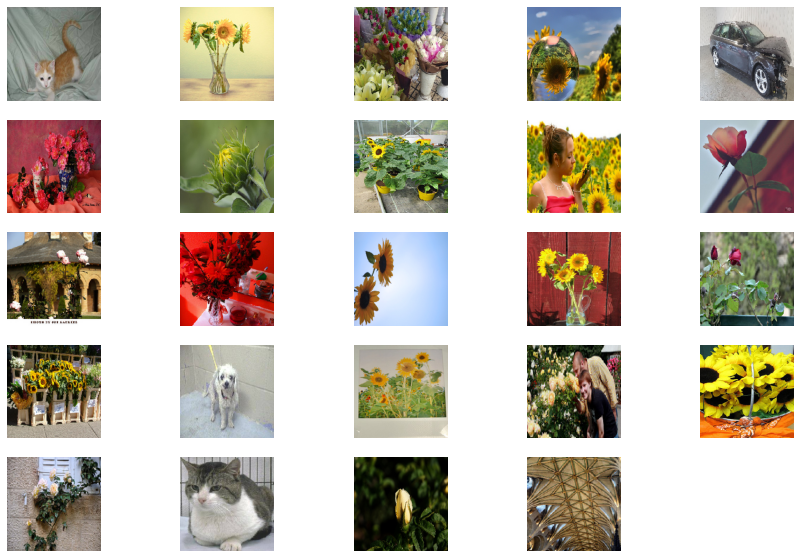

In [32]:
dict_ = print_flowers_cat(df, num= 24, label_text = ['Others', 'Roses', 'Sunflowers'])

Vemos cómo las flores se agrupan en 2 grupos de girasoles, otros 2 de rosas y uno compuesto mayoritariamente por otro tipo de imágenes.

Agrupamos las etiquetas y ponemos nombre a cada una:

In [33]:

df["kmeans_label_name"] = df.labels_kmeans.map(dict_)

Etiqueta:  Roses
Número de imágenes:  575


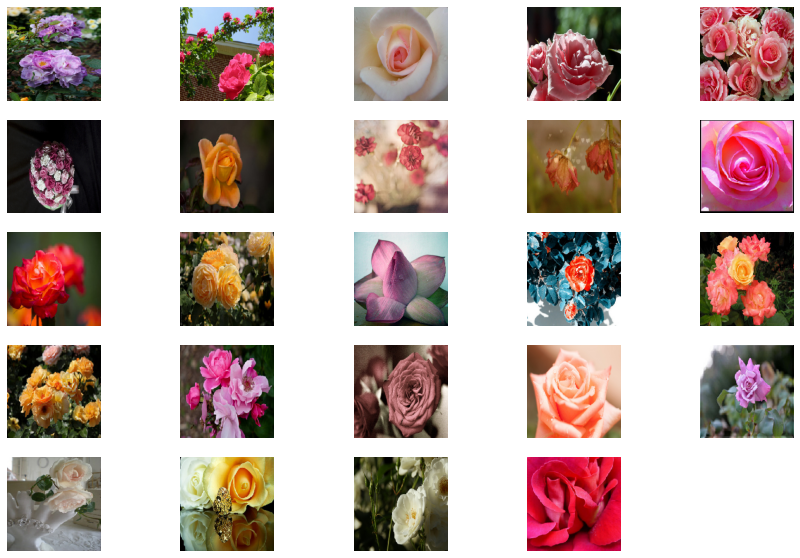

Etiqueta:  Sunflowers
Número de imágenes:  700


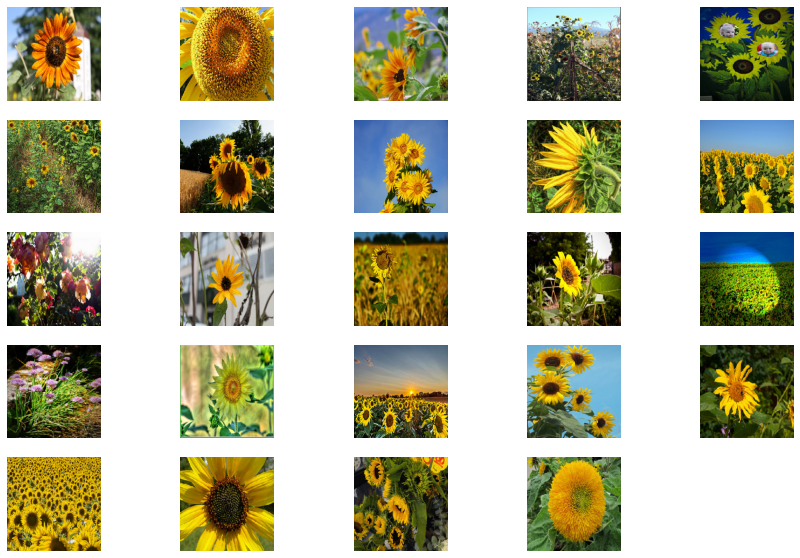

Etiqueta:  Others
Número de imágenes:  292


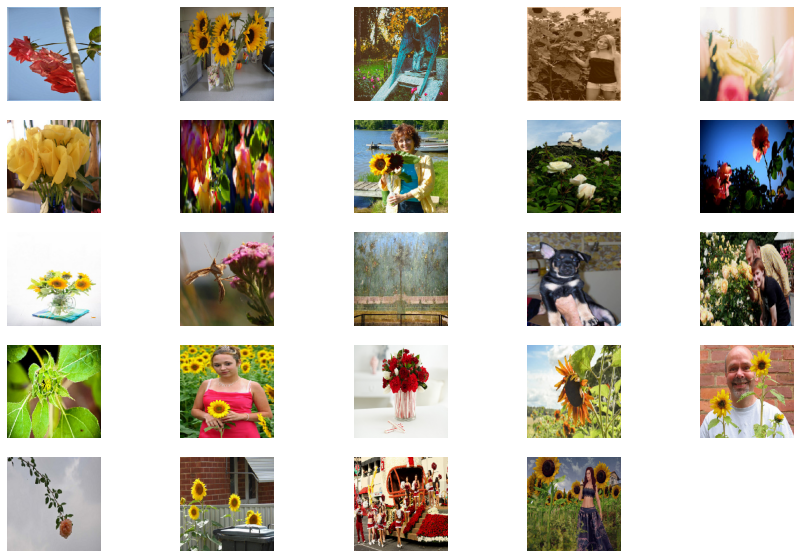

{}

In [34]:
print_flowers_cat(df, labels='kmeans_label_name', num= 24)

# MLP
Utilizamos un Multi-layer Perceptron classifier. En este caso, como buscamos huir del overfitting montamos un clasificador con muy pocas capas.

In [35]:
columns_dist=['dist_centroid_' + str(i) for i in range(k)]

scaler = StandardScaler()
df[pca_columns + columns_dist] = pd.DataFrame(scaler.fit_transform(df[pca_columns + columns_dist]))

In [36]:
clf = MLPClassifier(hidden_layer_sizes=(3,), max_iter=2000)

columns_dist=['dist_centroid_' + str(i) for i in range(k)]
clf.fit(df[columns_dist + pca_columns],df['labels_kmeans'])

MLPClassifier(hidden_layer_sizes=(3,), max_iter=2000)

In [37]:
df['labels_mplp'] = clf.predict(df[columns_dist + pca_columns])

Y la probabilidad.

In [38]:
df['mplp_predict_proba'] = clf.predict_proba(df[columns_dist + pca_columns]).tolist()

In [39]:

df["mlpc_label_name"] = df.labels_mplp.map(dict_)

Almacenamos la probabilidad con la que el Clsificador a elegido cada imagen

In [40]:
df = df.assign(mlp_predict_proba_single = df[['mplp_predict_proba', 'labels_mplp']].apply(lambda rows: rows[0][rows[1]], axis =1))

Algunas etiquetas coinciden con las del proceso de clustering pero otras no:

In [41]:
df_diff = df[df.labels_kmeans != df.labels_mplp]

Veamos los valores superiores de la red MLPC:

In [42]:
df_diff[['file', 'mlp_predict_proba_single']].sort_values('mlp_predict_proba_single', ascending = False).head(5)

file  mlp_predict_proba_single
1151   imagen801.jpg                  0.453955
1115  imagen1019.jpg                  0.448941
146    imagen500.jpg                  0.448018
217   imagen1501.jpg                  0.447797
950   imagen1437.jpg                  0.447470

Y los valores inferiores

In [43]:
df_diff[['file', 'mlp_predict_proba_single'] ].sort_values('mlp_predict_proba_single', ascending = False).tail(5)

file  mlp_predict_proba_single
964    imagen340.jpg                  0.365820
375   imagen1148.jpg                  0.365820
402    imagen777.jpg                  0.365820
1547   imagen447.jpg                  0.365820
738   imagen1419.jpg                  0.365681

In [44]:
df_diff = df[df.kmeans_label_name != df.mlpc_label_name]
print(f"No coinciden {df_diff.shape[0]} imágenes")


No coinciden 102 imágenes


In [45]:
df_diff[['kmeans_label_name', 'mlpc_label_name', 'mlp_predict_proba_single']].sort_values(by=['mlp_predict_proba_single'])

kmeans_label_name mlpc_label_name  mlp_predict_proba_single
738         Sunflowers           Roses                  0.365681
1034        Sunflowers           Roses                  0.365820
1031        Sunflowers           Roses                  0.365820
964         Sunflowers           Roses                  0.365820
927         Sunflowers           Roses                  0.365820
...                ...             ...                       ...
16              Others           Roses                  0.400712
671             Others           Roses                  0.401363
514             Others           Roses                  0.401708
925             Others           Roses                  0.401826
26              Others           Roses                  0.408891

[102 rows x 3 columns]

Y su distribución

Text(0, 0.5, 'Count')

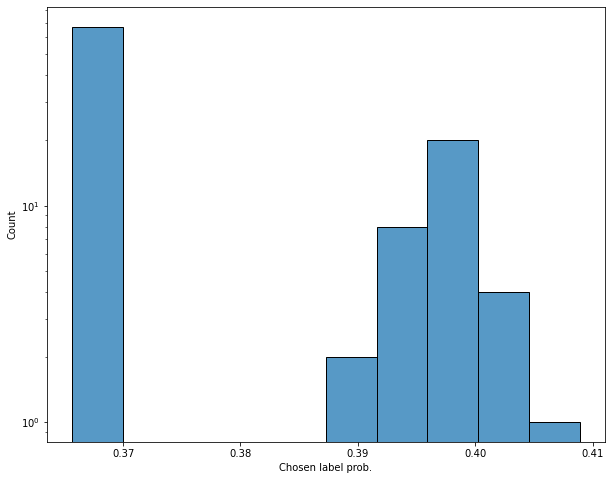

In [46]:
plt.figure(figsize=(10,8))
plt.yscale('log')
sns.histplot(df_diff['mlp_predict_proba_single'], bins=10)
plt.xlabel("Chosen label prob.")
plt.ylabel("Count")

Veamos algunas de ellas:

In [47]:
def print_flowers_diff(df, *args, num_examples = 9, col='image', size = (15,10)):
    """Función que imprime por consola un número imágenes aleatoriamente escogidas de un Pandas dataframe.

    Args:
        df (Pandas dataframe): Dataframe contenedor de imágenes
        num_examples (int, optional): Número de imágenes a mostrar. Defaults to 9.
        col (str, optional): Nombre de la columna que contiene las imágenes. Defaults to 'image'.
        size (tuple, optional): Tamaño de la figura que contiene las imágenes. Defaults to (15,10).
    """
    
    try:
        num_imgs_df = df.shape[0]
        num_imgs_show = min(num_examples, num_imgs_df)

        print("Número de imágenes: ", num_imgs_df)

        df_examples = df.sample(num_imgs_show).reset_index()
        gs = gridspec.GridSpec( int(np.ceil(np.sqrt(num_imgs_show))), int(np.ceil(np.sqrt(num_imgs_show))))
        gs.update(hspace = 0.75)
        plt.figure(figsize = size)

        for i in range(0, num_imgs_show):
            plt.subplot(gs[i])
            plt.imshow(df_examples.reset_index()[col][i])    
            tit = ["{}: {}".format(k,df_examples.loc[i,k]) for k in list(args)]
            plt.title('\n'.join(tit) + '\n' + str(round(df_examples.mlp_predict_proba_single[i],2)))
            plt.axis('off')
    except Exception as e:
        print("Ha surgido un problemaal imprimir")
        print(e)


Veamos las imágenes que diferencian entre uno y otro.

Número de imágenes:  102


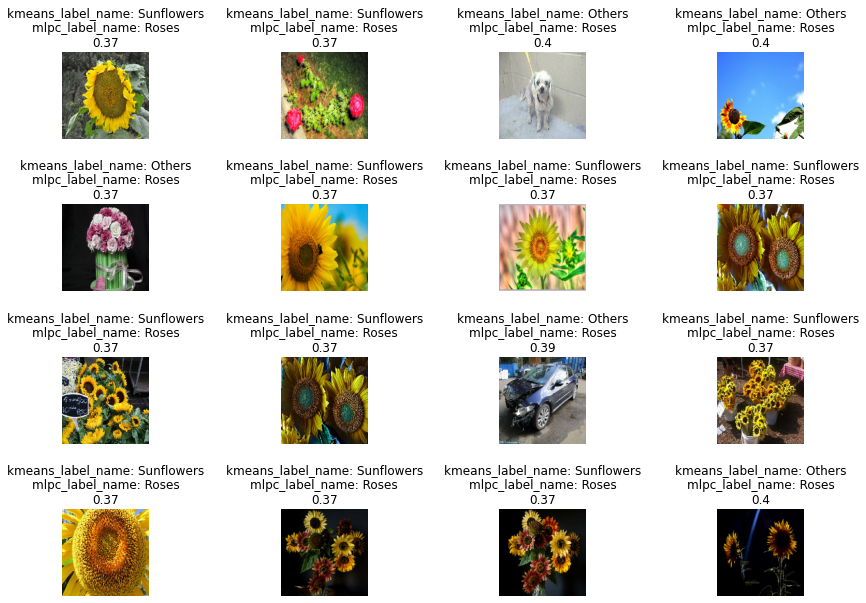

In [48]:
df_diff_print = df_diff[['image','kmeans_label_name', 'mlpc_label_name', 'mlp_predict_proba_single']]
print_flowers_diff(df_diff_print,'kmeans_label_name', 'mlpc_label_name', num_examples = 16)

In [49]:
def decide_label(row, th=0.5):
    """Función que utilizaremos para determinar la etiqueta final. 

    Args:
        row (PD Serie: Fila compuesta por ['labels_kmeans', 'labels_mplp', 'mlp_predict_proba_single']
        th (float, optional): Umbral para considerar si mantener la etiqueta del K means o el Clasificador. Defaults to 0.3.

    Returns:
        int : Etiqueta decidida.
    """
    if row[0] == row[1] or row[2] > th:
        return row[1]
    else:
        return row[0]
    

df = df.assign(label= df[['kmeans_label_name', 'mlpc_label_name', 'mlp_predict_proba_single']].apply(lambda rows: decide_label(rows, th=0.7), axis = 1 ))

In [50]:
df_diff = df[df.kmeans_label_name != df.mlpc_label_name]
df_diff_print = df_diff[['image','kmeans_label_name', 'mlpc_label_name', 'mlp_predict_proba_single','label']]


Número de imágenes:  102


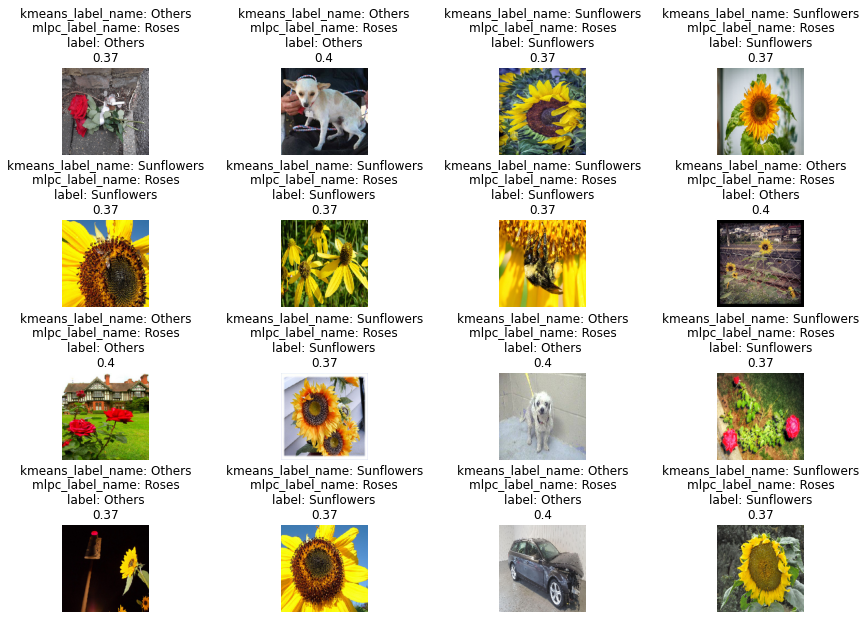

In [51]:
print_flowers_diff(df_diff_print,'kmeans_label_name', 'mlpc_label_name','label', num_examples = 16)

En esta imagen podemos ver algunos ejemplos del refinamiento. Las imagenes con etiquetas diferentes en las que la probaibilidad del mlpc es mayor que el umbral se corrigen.

En la siguiente gráfica podemos ver cómo se han distribuido las etiquetas

Text(0, 0.5, 'count')

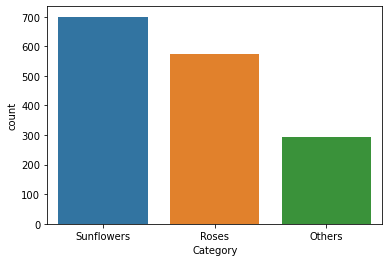

In [52]:
sns.countplot(data = df, x='label', order = df['label'].value_counts().index)
plt.xlabel("Category")
plt.ylabel("count")

En la siguiente gráfica podemos ver cuál ha sido la probabilidad que se ha dado para la etiqueta elegida

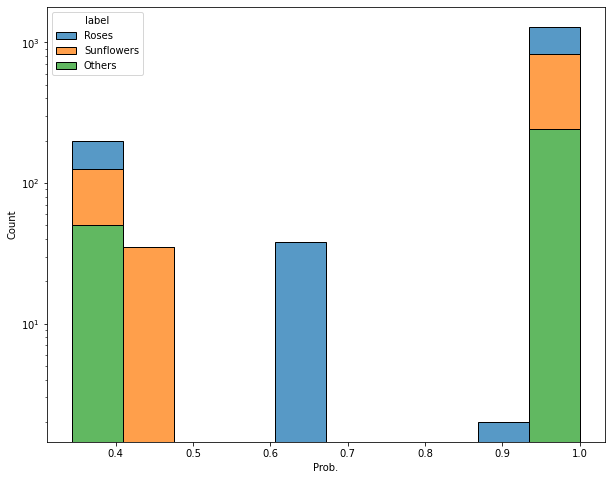

In [53]:
plt.figure(figsize=(10,8))
sns.histplot(df,x='mlp_predict_proba_single',hue='label', multiple='stack', bins=10)
plt.ylabel("Count")
plt.xlabel("Prob.")
plt.yscale('log')

En esta gráfica vemos como se distribuye las imágenes en función de la probabilidad resultante de MLPC. Las agrupamos por etiquetas. 

Por último guardamos las imágenes por carpetas con la fecha y hora del momento en que se ejecutó:



In [54]:
def save_img_cat_folder(df, folder,  labels= 'label'):
    date_time = datetime.now().strftime("%d%m%Y%H%M%S")
    dir_= os.path.join('./',folder + date_time)
    
    os.mkdir(dir_)
    
    for l in df[labels].unique():
        dir_cat= os.path.join(dir_,str(l))
        os.mkdir(dir_cat)

        files_paths = df[df[labels] == l ].path.tolist()
        files_names = df[df[labels] == l ].file.tolist()

        for origin_path, f_name in zip(files_paths, files_names):
            dir_dest = os.path.join(dir_cat, f_name)
            shutil.copy(origin_path, dir_dest)

In [55]:
save_img_cat_folder(df, 'Label Sunflower vs Roses',  labels= 'label')
